In [3]:
import numpy as np
import pandas as pd
import h5py
import torch
import os
import matplotlib.pyplot as plt

In [4]:
NUM_PLOTTED_CONDITIONS = 6
NUM_PLOTTED_CONDITIONS_WITH_GLOBAL = 10
NUM_CLIENTS = 14
NUM_FOLDS = 5

In [3]:
def load_final_model_performances(cv_results_path, filename, type=None, num_clients=14, num_folds=7, verbose=False):
    extraction_dict = dict()
    for i in range(num_folds):
        h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
        #print(h5_path)
        
        # Load data from HDF5 file
        with h5py.File(h5_path, 'r') as f:
            #print(f.keys())
            a_group_key = list(f.keys())
            for key in a_group_key:
                #print(key)
        
                if key=="client_local_test_log":
                    client_keys = list(f[key])
                    #print(client_keys)
                    for ck in client_keys:
                        ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                        #print(f"Key: {key}, Client: {ck}, Fold: {i}")
    
                        # So this doenst have any knoledge of the fold number???
                        if len(list(f[key][ck]))==0:
                            #print(f"{ed_key} SKIPPED!")
                            pass
                        else:
                            #print(f"{ed_key} SUCCESS!")
                            extraction_dict[ed_key] = list(f[key][ck])
                elif key=="global_test_error_log" and "NOFL" not in filename:
                    # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                elif key=="local_test_error_log":
                    # Genuinely have no idea what this is... is it client_local_test_log but already averaged out?? No clue
                    ed_key = f"{key}_fold{i}"
                    #print(ed_key)
                    extraction_dict[ed_key] = list(f[key])
                else:
                    pass
            #print()

    # So now that all that is extracted and saved to the dict, iterate through the dict and... average by client?
    client_logs = {f'S{i}_client_local_test_log': [] for i in range(num_clients)}  # S0 to S13
    global_test_log = []
    local_test_log = []
    for fold in range(num_folds):
        for i in range(num_clients):
            # Access client local test logs for each fold
            client_key = f'S{i}_client_local_test_log_fold{fold}'
            try:
                client_data = np.array(extraction_dict[client_key])
                #print(f"{client_key}: {client_data.shape}") --> It doesnt get to here if it fails!
    
                if len(client_logs[f'S{i}_client_local_test_log']) == 0:
                    client_logs[f'S{i}_client_local_test_log'] = client_data
                else:
                    client_logs[f'S{i}_client_local_test_log'] += client_data
                    
                #print(f"{client_key} SUCCESS!")
            except KeyError:
                # It was a testing client and thus not saved, so just skip to the next iter
                #print(f"{client_key} FAILED!")
                pass

        #print(filename)
        if "NOFL" in filename:
            pass
        else: 
            # Access global and local test logs for each fold
            global_key = f'global_test_error_log_fold{fold}'
            #print(extraction_dict.keys())
            global_data = extraction_dict[global_key][:]
            if len(global_test_log) == 0:
                global_test_log = np.array(global_data)
            else:
                global_test_log += np.array(global_data)
        
        local_key = f'local_test_error_log_fold{fold}'
        local_data = extraction_dict[local_key][:]
        if len(local_test_log) == 0:
            local_test_log = np.array(local_data)
        else:
            local_test_log += np.array(local_data)
    
    # Average the client test logs and the global/local test errors
    ## In the cross scenario, it should divide client_logs by 6, not 7, since each client is withheld once
    averaged_client_logs = {client: np.array(client_logs[client]) / num_folds for client in client_logs}
    if "NOFL" in filename:
        averaged_global_test_log = None
    else:    
        averaged_global_test_log = np.array(global_test_log) / num_folds
    averaged_local_test_log = np.array(local_test_log) / num_folds
    
    # Return the results
    return averaged_client_logs, averaged_global_test_log, averaged_local_test_log


# Sims Results Plot

In [4]:
results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results'
current_directory = r'\FinalSims'
base_path = results_path + current_directory

# CROSS
cpfa_avg_cli_logs, cpfa_avg_glo_tst_log, cpfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-07_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold', type="CROSS")
cfa_avg_cli_logs, cfa_avg_glo_tst_log, cfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-25_FEDAVG', 'GDLS_FEDAVG_KFold', type="CROSS")
cnofl_avg_cli_logs, _, cnofl_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-30_NOFL', 'FULLSCIPYMIN_NOFL_KFold', type="CROSS")
# INTRA
ipfa_avg_cli_logs, ipfa_avg_glo_tst_log, ipfa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-05_PFAFO_GDLS', 'GDLS_PFAFO_GDLS_KFold', type="INTRA")
ifa_avg_cli_logs, ifa_avg_glo_tst_log, ifa_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_23-04_FEDAVG', 'GDLS_FEDAVG_KFold', type="INTRA")
inofl_avg_cli_logs, _, inofl_avg_loc_tst_log = load_final_model_performances(base_path+r'\09-19_22-56_NOFL', 'FULLSCIPYMIN_NOFL_KFold', type="INTRA")


In [5]:
keys = list(cpfa_avg_cli_logs.keys())
keys

['S0_client_local_test_log',
 'S1_client_local_test_log',
 'S2_client_local_test_log',
 'S3_client_local_test_log',
 'S4_client_local_test_log',
 'S5_client_local_test_log',
 'S6_client_local_test_log',
 'S7_client_local_test_log',
 'S8_client_local_test_log',
 'S9_client_local_test_log',
 'S10_client_local_test_log',
 'S11_client_local_test_log',
 'S12_client_local_test_log',
 'S13_client_local_test_log']

In [6]:
cpfa_avg_cli_dict = {i: value for i, value in enumerate(cpfa_avg_cli_logs.values())}
cfa_avg_cli_dict = {i: value for i, value in enumerate(cfa_avg_cli_logs.values())}
cnofl_avg_cli_dict = {i: value for i, value in enumerate(cnofl_avg_cli_logs.values())}
ipfa_avg_cli_dict = {i: value for i, value in enumerate(ipfa_avg_cli_logs.values())}
ifa_avg_cli_dict = {i: value for i, value in enumerate(ifa_avg_cli_logs.values())}
inofl_avg_cli_dict = {i: value for i, value in enumerate(inofl_avg_cli_logs.values())}


In [7]:
def mean_of_last_n(values, n=10):
    return np.mean(values[-n:])

# Create lists by calculating the mean of the last 10 values
cpfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cpfa_avg_cli_logs.values()]
cfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cfa_avg_cli_logs.values()]
cnofl_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in cnofl_avg_cli_logs.values()]
ipfa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in ipfa_avg_cli_logs.values()]
ifa_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in ifa_avg_cli_logs.values()]
inofl_avg_cli_lst = [mean_of_last_n(cli_log) for cli_log in inofl_avg_cli_logs.values()]


In [8]:
inofl_avg_cli_lst

[1.1333130999467099e-06,
 1.3238447333338317e-06,
 7.707713509172294e-07,
 1.348189332332271e-06,
 1.1211532913911374e-06,
 7.423655174816078e-07,
 6.65638785747948e-07,
 1.0537339687917913e-06,
 4.778083428939015e-07,
 9.96157949158905e-07,
 8.79757827888439e-07,
 8.872193781093957e-07,
 4.0692453245539416e-07,
 4.620277913358508e-07]

In [9]:
#cli_fold_log_lst = 
INTRA_cli_fold_log_lst = [inofl_avg_cli_dict, ifa_avg_cli_dict, ipfa_avg_cli_dict]
CROSS_cli_fold_log_lst = [cnofl_avg_cli_dict, cfa_avg_cli_dict, cpfa_avg_cli_dict]

INTRA_finalavg_cli_fold_log_lst = [inofl_avg_cli_lst, ifa_avg_cli_lst, ipfa_avg_cli_lst]
CROSS_finalavg_cli_fold_log_lst = [cnofl_avg_cli_lst, cfa_avg_cli_lst, cpfa_avg_cli_lst]

all_trials_lst = [inofl_avg_cli_lst, ifa_avg_cli_lst, ipfa_avg_cli_lst, cnofl_avg_cli_lst, cfa_avg_cli_lst, cpfa_avg_cli_lst]

In [61]:

# Define the scenario and algorithm information
scenarios = ['Intra-Subject'] * 3 + ['Cross-Subject'] * 3
algorithms = ['LocalBatchMin', 'FedAvg', 'Per-FedAvg', 'LocalBatchMin', 'FedAvg', 'Per-FedAvg']

# Create an empty list to store rows
rows = []

# Loop over each trial result, scenario, and algorithm to create rows
for i, trial_results in enumerate(all_trials_lst):
    for client_idx, result in enumerate(trial_results):
        rows.append([scenarios[i], algorithms[i], client_idx + 1, result])

# Convert to a DataFrame
df = pd.DataFrame(rows, columns=['Scenario', 'Algorithm', 'Client', 'Test Loss'])

print(df.shape)
df.head()

(84, 4)


,Scenario,Algorithm,Client,Test Loss
0,Intra-Subject,LocalBatchMin,1,1.133313e-06
1,Intra-Subject,LocalBatchMin,2,1.323845e-06
2,Intra-Subject,LocalBatchMin,3,7.707714e-07
3,Intra-Subject,LocalBatchMin,4,1.348189e-06
4,Intra-Subject,LocalBatchMin,5,1.121153e-06


In [68]:
# Save the DataFrame to a CSV file
#df.to_csv('sim__results_condition_losses.csv', index=False)

In [63]:

# Create an empty list to store rows
rows = []

# Loop over each trial result, scenario, and algorithm to create rows
for i, trial_results in enumerate(all_trials_lst):
    row = [scenarios[i], algorithms[i]] + trial_results
    rows.append(row)

# Create DataFrame with columns for each client
columns = ['Scenario', 'Algorithm'] + [f'Test Loss Client_{j+1}' for j in range(len(all_trials_lst[0]))]
df = pd.DataFrame(rows, columns=columns)

print(df.shape)
df.head()

(6, 16)


,Scenario,Algorithm,Test Loss Client_1,Test Loss Client_2,Test Loss Client_3,Test Loss Client_4,Test Loss Client_5,Test Loss Client_6,Test Loss Client_7,Test Loss Client_8,Test Loss Client_9,Test Loss Client_10,Test Loss Client_11,Test Loss Client_12,Test Loss Client_13,Test Loss Client_14
0,Intra-Subject,LocalBatchMin,1.133313e-06,1.323845e-06,7.707714e-07,1.348189e-06,1.121153e-06,7.423655e-07,6.656388e-07,1.053734e-06,4.778083e-07,9.961579e-07,8.797578e-07,8.872194e-07,4.069245e-07,4.620278e-07
1,Intra-Subject,FedAvg,5.578730e-07,5.579989e-07,6.143980e-07,6.757203e-07,6.381545e-07,5.310318e-07,5.191022e-07,5.030276e-07,4.295063e-07,5.341212e-07,5.478236e-07,5.290059e-07,4.401371e-07,4.423357e-07
2,Intra-Subject,Per-FedAvg,7.938604e-07,8.043917e-07,8.885709e-07,8.650150e-07,8.074904e-07,7.019685e-07,6.695490e-07,6.937197e-07,4.917581e-07,6.850316e-07,7.932000e-07,7.573918e-07,5.427926e-07,5.549266e-07
3,Cross-Subject,LocalBatchMin,4.074979e-03,5.164923e-03,4.716512e-03,4.174560e-03,4.964350e-03,4.921355e-03,5.980499e-03,7.084225e-03,6.612236e-03,4.799999e-03,4.813089e-03,3.569071e-03,6.851207e-03,8.111559e-03
4,Cross-Subject,FedAvg,1.358644e-03,1.355207e-03,1.353212e-03,1.354346e-03,1.352622e-03,1.348840e-03,1.381575e-03,1.374582e-03,1.394263e-03,1.387676e-03,1.395097e-03,1.390397e-03,1.385256e-03,1.383304e-03


In [67]:
#cpfa_final_global_loss = mean_of_last_n(cpfa_avg_glo_tst_log)
#cfa_final_global_loss = mean_of_last_n(cfa_avg_glo_tst_log)
#ipfa_final_global_loss = mean_of_last_n(ipfa_avg_glo_tst_log)
#ifa_final_global_loss = mean_of_last_n(ifa_avg_glo_tst_log)

> In intra: global model is evaluated but on many separate test sets... so there should be a per client global loss...

            - Is what I have for intra global loss rn just the averaged loss across each clients local test set? Not sure... but presumably...

> In cross: global model is evaulated on a single aggregated test set, so there is only a single loss vector

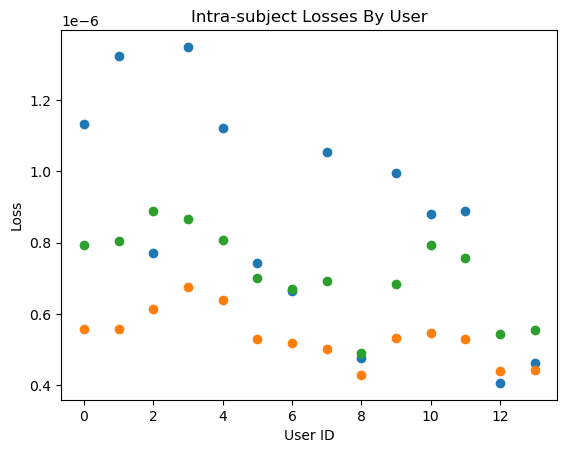

In [10]:
for cli_fold_log in INTRA_finalavg_cli_fold_log_lst:
    plt.scatter(range(len(cli_fold_log)), cli_fold_log)
plt.title("Intra-subject Losses By User")
plt.ylabel('Loss')
plt.xlabel('User ID')
plt.show()

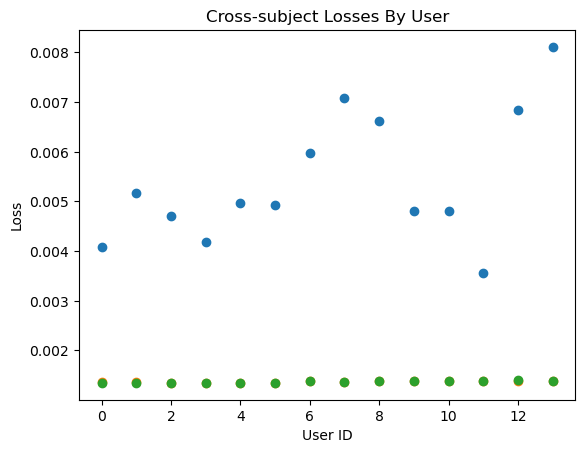

In [11]:
for cli_fold_log in CROSS_finalavg_cli_fold_log_lst:
    plt.scatter(range(len(cli_fold_log)), cli_fold_log)
plt.title("Cross-subject Losses By User")
plt.ylabel('Loss')
plt.xlabel('User ID')
plt.show()

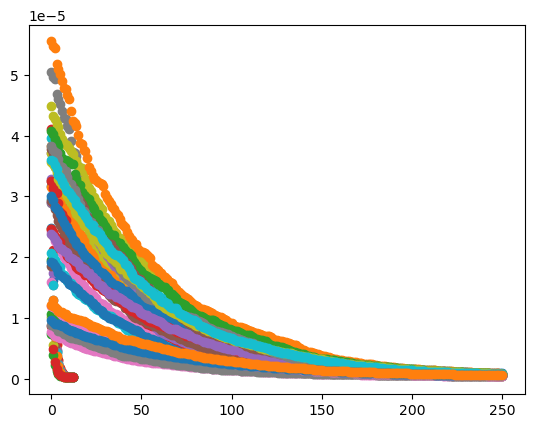

In [12]:
for cli_idx, cli_fold_log in enumerate(INTRA_cli_fold_log_lst):
    for cli_idx in range(NUM_CLIENTS):
        plt.scatter(range(len(cli_fold_log[cli_idx])), cli_fold_log[cli_idx])

> Global models:

In [18]:
cpfa_final_global_loss = mean_of_last_n(cpfa_avg_glo_tst_log)
cfa_final_global_loss = mean_of_last_n(cfa_avg_glo_tst_log)
ipfa_final_global_loss = mean_of_last_n(ipfa_avg_glo_tst_log)
ifa_final_global_loss = mean_of_last_n(ifa_avg_glo_tst_log)


In [19]:
print(f"cpfa_final_global_loss: {cpfa_final_global_loss}")
print(f"cfa_final_global_loss: {cfa_final_global_loss}")
print(f"ipfa_final_global_loss: {ipfa_final_global_loss}")
print(f"ifa_final_global_loss: {ifa_final_global_loss}")

cpfa_final_global_loss: 0.0015942996455851697
cfa_final_global_loss: 0.001596315203530286
ipfa_final_global_loss: 7.43501161601078e-07
ifa_final_global_loss: 5.524318974783417e-07


## Performance: Final Avg Test Loss

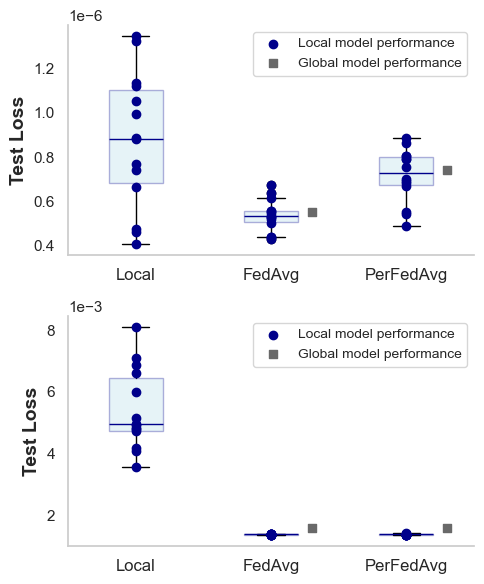

In [56]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels
x_labels_intra = ['Local', 'FedAvg', 'PerFedAvg']
x_labels_cross = ['Local', 'FedAvg', 'PerFedAvg']

# Positions for the local and global data points
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width
# Intra-subject (first subplot)
all_trials_intra = all_trials_lst[:3]
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)
# Cross-subject (second subplot)
all_trials_cross = all_trials_lst[3:]
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
light_grey = 'lightgrey'
dark_grey = 'dimgrey'
offset = 0.3
global_model_marker = 's'  # square marker for global model

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Scatter plots for local points (full opacity, no alpha)
for i in range(len(all_trials_lst)):
    if i < 3:  # Intra-subject case (first subplot)
        ax1.scatter([i] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')
    else:  # Cross-subject case (second subplot)
        ax2.scatter([i - 3] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')

# Scatter plots for global model points (light grey, offset on x-axis, full opacity)
global_model_data = [ifa_final_global_loss, ipfa_final_global_loss, cfa_final_global_loss, cpfa_final_global_loss]

for i, global_loss in enumerate(global_model_data[:2]):
    ax1.scatter([i+1 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

for i, global_loss in enumerate(global_model_data[2:], start=3):
    ax2.scatter([i+1 - 3 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Test Loss", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates
#
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates
#
# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
plt.savefig('SimsResults_OffsetGlobal.jpg', dpi=500)
plt.show()


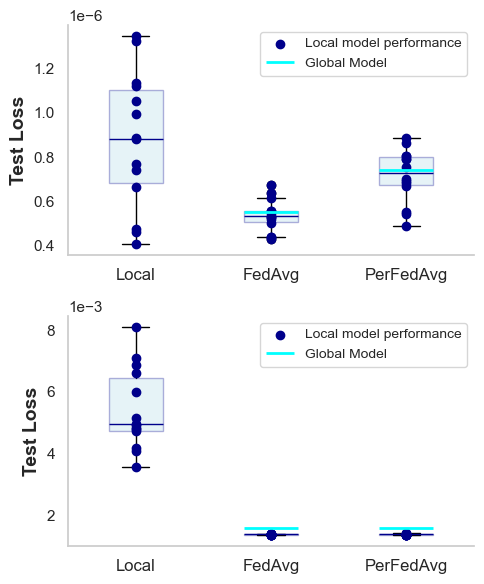

In [57]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels
x_labels_intra = ['Local', 'FedAvg', 'PerFedAvg']
x_labels_cross = ['Local', 'FedAvg', 'PerFedAvg']

# Positions for the local and global data points
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width
# Intra-subject (first subplot)
all_trials_intra = all_trials_lst[:3]
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)
# Cross-subject (second subplot)
all_trials_cross = all_trials_lst[3:]
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
light_grey = 'lightgrey'
dark_grey = 'dimgrey'
cyan = 'cyan'  # cyan color for global model line

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Scatter plots for local points (full opacity, no alpha)
for i in range(len(all_trials_lst)):
    if i < 3:  # Intra-subject case (first subplot)
        ax1.scatter([i] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')
    else:  # Cross-subject case (second subplot)
        ax2.scatter([i - 3] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')

# Global model data for cyan line on box plots
global_model_data = [ifa_final_global_loss, ipfa_final_global_loss, cfa_final_global_loss, cpfa_final_global_loss]

# Plot cyan lines for global model performance on the box plots (same as median line)
# For intra-subject (ax1)
global_positions = [1, 2]
for i, global_loss in enumerate(global_model_data[:2]):
    ax1.hlines(global_loss, global_positions[i] - box_width / 2, global_positions[i] + box_width / 2, color=cyan, linewidth=2, label='Global Model', zorder=2)
# For cross-subject (ax2)
for i, global_loss in enumerate(global_model_data[2:], start=0):
    ax2.hlines(global_loss, global_positions[i] - box_width / 2, global_positions[i] + box_width / 2, color=cyan, linewidth=2, label='Global Model', zorder=2)

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Test Loss", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates
#
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates
#
# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
plt.savefig('SimsResults_CyanGlobal.jpg', dpi=500)
plt.show()


## Final Avg Performance Error

In [ ]:
# Calculate the average time-domain error across all subjects

time_x = times_block1[k][c]
td_error = np.empty((2, len(keys), len(conds), min_time)) # len(update_ix)-2 so we can avoid the last interval

# get the time-domain error average across batches
for iK, key in enumerate(keys):
    for iC, cond in enumerate(conds):
        # BLOCK 1
        b = 0
        ref = refs_block1[key][iC] # ref = time x 2
        pos = poss_block1[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
        # BLOCK 2
        b = 1
        ref = refs_block2[key][iC] # ref = time x 2
        pos = poss_block2[key][iC] # pos = time x 2
        td_error[b, iK, iC, :] = calc_time_domain_error(ref, pos)
        
# first 20 seconds after ramp 
t0_start = RAMP 
t0_end = int(tscale*25)-1 # so that both times are the same 
print("first 20 seconds after ramp, starting at index: ", t0_start, "ending at index: ", t0_end)

# take the average of the first 20 seconds across subjects, blocks and conditions
td_error_first = np.mean(td_error[:, :, :, t0_start:t0_end], axis = -1) # 2 x 7 x 8
assert(td_error_first.shape == (2, len(keys), len(conds)))

# last 20 seconds
t1_end = int(tscale*20)
print("last 20 seconds, starting at index: ", t1_end)

# make sure that the time lengths are the same
assert((t0_end - t0_start) == t1_end)

# take average of the last 20 seconds, across subjects blocks and conditions
td_error_last = np.mean(td_error[:, :, :, -t1_end:], axis=-1) # -t1_end takes the last 20 seconds index
assert(td_error_last.shape == (2, len(keys), len(conds)))

# BLOCK 1 - without the 5 seconds ramp
b = 0
td_b1_25, td_b1_50, td_bl_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b1_50)
plt.fill_between(time_x[t0_start:], td_b1_25, td_bl_75, alpha=0.2)

# BLOCK 2 - without the 5 seconds ramp
b = 1
td_b2_25, td_b2_50, td_b2_75 = np.percentile(td_error[b, :, :, t0_start:], [25, 50, 75], axis=(0, 1))
plt.plot(time_x[t0_start:], td_b2_50)
plt.fill_between(time_x[t0_start:], td_b2_25, td_b2_75, alpha=0.2)

plt.title("Comparing time-domain error without the ramp")
plt.xlabel("time (seconds)")
plt.ylabel("$||t - y||_2$")
plt.box(False)

In [ ]:
'10-03_14-45_FEDAVG'

In [14]:
import os

#def load_final_model_performances(cv_results_path, filename, type=None, num_clients=14, num_folds=7, verbose=False):
#def load_final_model_performances(
cv_results_path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\PythonVersion\PythonSimsRevamp\results\10-03_15-17_FEDAVG'
filename = 'GDLS_FEDAVG_KFold'
type=None
num_clients=14
num_folds= 1 #7
verbose=False



extraction_dict = dict()
for i in range(num_folds):
    h5_path = os.path.join(cv_results_path, filename+f"{i}.h5")
    #print(h5_path)
    
    # Load data from HDF5 file
    with h5py.File(h5_path, 'r') as f:
        print(f.keys())
        a_group_key = list(f.keys())
        for key in a_group_key:
            #print(key)
    
            if key=="client_global_cost_func_comps_log": #client_local_cost_func_comps_log
                client_keys = list(f[key])
                print("key {key}; client keys:")
                print(client_keys)
                for ck in client_keys:
                    ed_key = f"{ck}_fold{i}"  # Does this never update from or something...
                    #print(f"Key: {key}, Client: {ck}, Fold: {i}")

                    # So this doenst have any knoledge of the fold number???
                    if len(list(f[key][ck]))==0:
                        val = list(f[key][ck])
                        print(f"{ed_key} SKIPPED!")
                        pass
                    else:
                        print(f"{ed_key} SUCCESS!")
                        extraction_dict[ed_key] = list(f[key][ck])
            elif key=="global_test_error_log" and "NOFL" not in filename:
                # Do I need to turn this off for NoFL? Or will it just be empty and append something empty...
                ed_key = f"{key}_fold{i}"
                print(ed_key)
                extraction_dict[ed_key] = list(f[key])
            elif key=="local_test_error_log":
                # Genuinely have no idea what this is... is it client_local_test_log but already averaged out?? No clue
                ed_key = f"{key}_fold{i}"
                print(ed_key)
                extraction_dict[ed_key] = list(f[key])
            else:
                print(f"key {key} NOT ADDED")
                pass

# Average the client test logs and the global/local test errors
## In the cross scenario, it should divide client_logs by 6, not 7, since each client is withheld once
averaged_client_logs = {client: np.array(client_logs[client]) / num_folds for client in client_logs}
if "NOFL" in filename:
    averaged_global_test_log = None
else:    
    averaged_global_test_log = np.array(global_test_log) / num_folds
averaged_local_test_log = np.array(local_test_log) / num_folds

# Return the results
#return averaged_client_logs, averaged_global_test_log, averaged_local_test_log


<KeysViewHDF5 ['client_global_cost_func_comps_log', 'client_local_cost_func_comps_log', 'client_local_model_log', 'client_local_test_log', 'global_dec_log', 'global_test_error_log', 'global_train_error_log', 'gradient_norm_lists_by_client', 'local_test_error_log', 'local_train_error_log']>
key {key}; client keys:
['S0_client_global_cost_func_comps_log', 'S10_client_global_cost_func_comps_log', 'S11_client_global_cost_func_comps_log', 'S12_client_global_cost_func_comps_log', 'S13_client_global_cost_func_comps_log', 'S1_client_global_cost_func_comps_log', 'S2_client_global_cost_func_comps_log', 'S3_client_global_cost_func_comps_log', 'S4_client_global_cost_func_comps_log', 'S5_client_global_cost_func_comps_log', 'S6_client_global_cost_func_comps_log', 'S7_client_global_cost_func_comps_log', 'S8_client_global_cost_func_comps_log', 'S9_client_global_cost_func_comps_log']
S0_client_global_cost_func_comps_log_fold0 SKIPPED!
S10_client_global_cost_func_comps_log_fold0 SUCCESS!
S11_client_glob

In [ ]:
# Now write some extraction code
#normalized_test_loss, normalized_vel_error, normalized_dec_error

# Extract the 2nd (eg index 1) ele from each tuple of the list

In [17]:
extraction_dict.keys()

dict_keys(['S10_client_global_cost_func_comps_log_fold0', 'S11_client_global_cost_func_comps_log_fold0', 'S12_client_global_cost_func_comps_log_fold0', 'S13_client_global_cost_func_comps_log_fold0', 'S2_client_global_cost_func_comps_log_fold0', 'S3_client_global_cost_func_comps_log_fold0', 'S4_client_global_cost_func_comps_log_fold0', 'S5_client_global_cost_func_comps_log_fold0', 'S6_client_global_cost_func_comps_log_fold0', 'S7_client_global_cost_func_comps_log_fold0', 'S8_client_global_cost_func_comps_log_fold0', 'S9_client_global_cost_func_comps_log_fold0', 'global_test_error_log_fold0', 'local_test_error_log_fold0'])

In [18]:
client_perf_error_dict = {}
for key in list(extraction_dict.keys()):
    # Wrap this in for fold in range(num_folds):
    if 'global_cost_func_comps_log' in key:
        list_of_tuples = extraction_dict[key]
        if len(list_of_tuples)!=0:
            perf_error_lst = [ele[1] for ele in list_of_tuples]
            client_perf_error_dict[key] = perf_error_lst
        else:
            # Else it was a testing client
            pass



    

In [21]:
for key in list(client_perf_error_dict.keys()):
    print(key)
    print(np.mean(client_perf_error_dict[key][:10]))
    print(np.mean(client_perf_error_dict[key][-10:]))
    print()

    # I need to like average this by client

S10_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S11_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S12_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S13_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S2_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S3_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S4_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S5_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S6_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S7_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S8_client_global_cost_func_comps_log_fold0
0.2984378080670399
0.0017210877290154002

S9_client_global_cost_func_comps_log_fold0
0.2984378080670399

In [ ]:
# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Set up the figure and two subplots (without shared x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6))

# Define x-tick labels
x_labels_intra = ['Local', 'FedAvg', 'PerFedAvg']
x_labels_cross = ['Local', 'FedAvg', 'PerFedAvg']

# Positions for the local and global data points
positions_intra = np.arange(len(x_labels_intra))
positions_cross = np.arange(len(x_labels_cross))

# BOX PLOTS
box_width = 0.4  # Reduce the box plot width
# Intra-subject (first subplot)
all_trials_intra = all_trials_lst[:3]
boxplot_elements1 = ax1.boxplot(all_trials_intra, positions=positions_intra, widths=box_width, patch_artist=True, zorder=0)
# Cross-subject (second subplot)
all_trials_cross = all_trials_lst[3:]
boxplot_elements2 = ax2.boxplot(all_trials_cross, positions=positions_cross, widths=box_width, patch_artist=True, zorder=0)

# Colors and adjustments
light_blue = 'lightblue'
dark_blue = 'darkblue'
light_grey = 'lightgrey'
dark_grey = 'dimgrey'
offset = 0.3
global_model_marker = 's'  # square marker for global model

# Customize boxplot colors (set somewhat transparent boxes)
for box in boxplot_elements1['boxes'] + boxplot_elements2['boxes']:
    box.set_facecolor(light_blue)
    box.set_edgecolor(dark_blue)
    box.set_alpha(0.3)  # Adjust transparency to see scatter points more clearly

# Set median color to a darker shade of blue
for median in boxplot_elements1['medians'] + boxplot_elements2['medians']:
    median.set_color(dark_blue)

# Scatter plots for local points (full opacity, no alpha)
for i in range(len(all_trials_lst)):
    if i < 3:  # Intra-subject case (first subplot)
        ax1.scatter([i] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')
    else:  # Cross-subject case (second subplot)
        ax2.scatter([i - 3] * len(all_trials_lst[i]), all_trials_lst[i], color=dark_blue, zorder=1, label='Local model performance')

# Scatter plots for global model points (light grey, offset on x-axis, full opacity)
global_model_data = [ifa_final_global_loss, ipfa_final_global_loss, cfa_final_global_loss, cpfa_final_global_loss]

for i, global_loss in enumerate(global_model_data[:2]):
    ax1.scatter([i+1 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

for i, global_loss in enumerate(global_model_data[2:], start=3):
    ax2.scatter([i+1 - 3 + offset], global_loss, color=dark_grey, zorder=2, marker=global_model_marker, label='Global model performance')

# Set consistent font sizes for both plots
for ax in [ax1, ax2]:
    ax.set_ylabel("Test Loss", fontsize=14, weight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Set x-tick labels individually for each plot
ax1.set_xticks(positions_intra)
ax1.set_xticklabels(x_labels_intra, fontsize=12)

ax2.set_xticks(positions_cross)
ax2.set_xticklabels(x_labels_cross, fontsize=12)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# After plotting points and boxplots in ax1 and ax2
handles_ax1, labels_ax1 = ax1.get_legend_handles_labels()
unique_ax1 = dict(zip(labels_ax1, handles_ax1))  # Removes duplicates
#
handles_ax2, labels_ax2 = ax2.get_legend_handles_labels()
unique_ax2 = dict(zip(labels_ax2, handles_ax2))  # Removes duplicates
#
# Set legends with unique labels for both subplots
ax1.legend(unique_ax1.values(), unique_ax1.keys(), loc='upper right', fontsize=10)
ax2.legend(unique_ax2.values(), unique_ax2.keys(), loc='upper right', fontsize=10)

ax1.grid(False)
ax2.grid(False)

plt.tight_layout()

# Save and show the figure
plt.savefig('SimsResults_OffsetGlobal.jpg', dpi=500)
plt.show()
